In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv("visem 0.2/semen_analysis_data_Train.csv", low_memory=False, encoding ='utf8',sep=",")

df.head()

,ID,Sperm concentration (x10⁶/mL),Total sperm count (x10⁶),Ejaculate volume (mL),Sperm vitality (%),Normal spermatozoa (%),Head defects (%),Midpiece and neck defects (%),Tail defects (%),Cytoplasmic droplet (%),Teratozoospermia index,Progressive motility (%),Non progressive sperm motility (%),Immotile sperm (%),"High DNA stainability, HDS (%)","DNA fragmentation index, DFI (%)"
0,11,97.0,129.0,1.3,80,2.4,97.0,28.0,9.7,7.3,1.45,11,17,72,6,24
1,12,29.4,213.9,7.3,94,2.5,96.0,33.3,14.9,6.5,1.55,33,54,13,10,8
2,13,74.4,136.1,1.8,88,3.9,96.0,31.0,5.8,3.9,1.42,33,30,37,10,4
3,14,3.8,6.9,1.8,96,4.0,96.0,36.0,17.0,7.5,1.63,41,43,16,13,15
4,15,4.0,5.8,1.4,93,0.0,100.0,50.5,21.5,6.0,1.78,15,46,39,27,28


In [21]:
df.columns.tolist()

['ID',
 'Sperm concentration (x10⁶/mL)',
 'Total sperm count (x10⁶)',
 'Ejaculate volume (mL)',
 'Sperm vitality (%)',
 'Normal spermatozoa (%)',
 'Head defects (%)',
 'Midpiece and neck defects (%)',
 'Tail defects (%)',
 'Cytoplasmic droplet (%)',
 'Teratozoospermia index',
 'Progressive motility (%)',
 'Non progressive sperm motility (%)',
 'Immotile sperm (%)',
 'High DNA stainability, HDS (%)',
 'DNA fragmentation index, DFI (%)']

In [22]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [23]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [24]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [25]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [26]:
df = df.rename(columns={'Sperm concentration (x10⁶/mL)':'concentration', 'Sperm vitality (%)': 'vitality', 'Normal spermatozoa (%)': 'normal', 'Tail defects (%)': 'tail', 'Immotile sperm (%)': 'immotile', 'Progressive motility (%)': 'progressiv', 'High DNA stainability, HDS (%)': 'hds', 'DNA fragmentation index, DFI (%)': 'dfi', 'Non progressive sperm motility (%)': 'non_progressive'})

In [27]:
features = [
    "concentration",
    "vitality",
    "progressiv",
    "dfi",
]

print("Correlation with Immotility:\n")
print(df[features].corrwith(df.immotile))

Correlation with Immotility:

concentration    0.133496
vitality        -0.363534
progressiv      -0.839919
dfi              0.403655
dtype: float64


In [28]:
X = df.copy()
y = X.pop("immotile")
X = X.loc[:, features]


pca, X_pca, loadings = apply_pca(X)
print(loadings)

                    PC1       PC2       PC3       PC4
concentration  0.275960  0.622130  0.662527  0.312824
vitality      -0.179063  0.660173 -0.675425  0.275517
progressiv    -0.648508  0.342034  0.247932 -0.633230
dfi            0.686455  0.245233 -0.208299 -0.652113


In [11]:
X = df.copy()
y = X.pop("immotile")


X["Feature1"] = X.concentration + X.vitality
X["Feature2"] = X.progressiv * X.dfi #I changed since I got error float and method. So I chose integers

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.37392 RMSLE


In [12]:
X = df.copy()
y = X.pop("immotile")


X = X.join(X_pca)

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.33746 RMSLE


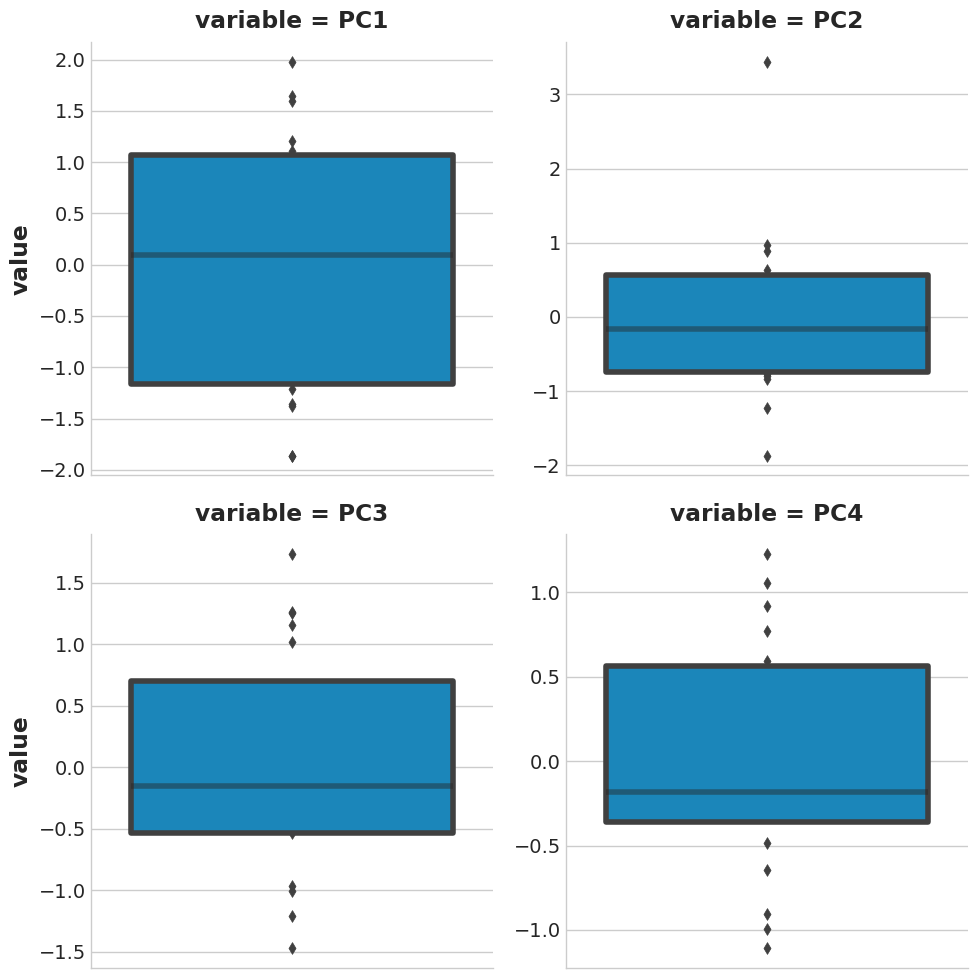

In [13]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [14]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["immotile", "non_progressive", "hds"] + features]

,immotile,non_progressive,hds,concentration,vitality,progressiv,dfi
15,46,42,5,30.5,78,12,35
9,40,25,6,159.0,95,35,36
0,72,17,6,97.0,80,11,24
10,76,20,14,4.2,81,4,24
12,73,26,15,33.8,83,1,19
16,54,32,8,6.9,70,14,24
4,39,46,27,4.0,93,15,28
17,41,37,9,19.8,95,22,26
6,39,31,17,28.1,95,30,27
8,48,34,17,4.5,85,18,19


In [15]:
component = "PC4"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["immotile", "non_progressive", "hds"] + features]

,immotile,non_progressive,hds,concentration,vitality,progressiv,dfi
2,37,30,10,74.4,88,33,4
19,50,33,13,22.0,85,17,8
12,73,26,15,33.8,83,1,19
1,13,54,10,29.4,94,33,8
11,34,40,14,39.6,91,26,14
0,72,17,6,97.0,80,11,24
18,37,44,21,13.4,87,19,18
10,76,20,14,4.2,81,4,24
8,48,34,17,4.5,85,18,19
17,41,37,9,19.8,95,22,26
